# Lab 3 - Maze Game as a Markov Decision Process Part 2

## **1. Objectives**

Last week in Lab 2, we  

- Modeled a simple **maze game** as a **Markov Decision Process (MDP)** by defining:
  - **States**
  - **Actions**
  - **Transition probabilities**
  - **Rewards**

- Implemented **policy evaluation** to compute the value function of a given policy.

We consider a **discounted MDP** with discount factor  $\gamma \in (0,1)$.


This week, we will use **dynamic programming** to find **an optimal policy**.

**<span style="color:red;">Important: Lab 3 starts with Question 12. Questions 1–11 are already included in Lab 2.</span>**



In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# (not mandatory) This line is for limiting floats to 3 decimal places,
# avoiding scientific notation (like 1.23e-04) for small numbers.

# For reproducibility
rng = np.random.default_rng(seed=42)  # This line creates a random number generator.


## 2. Maze definition and MDP formulation

We consider a small 2D maze on a grid. The agent is a **robot** that moves on the grid.

- `S` : start state
- `G` : goal state, with positive reward
- `#` : wall (not accessible)
- `.` : empty cell
- `X` : "trap" (negative reward)

At each step, the robot can choose among 4 actions:

$$
\mathcal{A} = \{\text{Up} \uparrow, \quad \text{Right} \rightarrow, \quad \text{Down} \downarrow, \quad \text{Left}\leftarrow\}.
$$

The movement is deterministic, but here we set a small probability of “error” to make the example more realistic.
- With probability $1 - p_{\text{error}}$, it moves in the chosen direction.
- With probability $p_{\text{error}}$, it moves in a random *other* direction.
- If the movement would hit a wall or go outside the grid, the agent stays in place.

We will represent the MDP with:

- A list of **states $\mathcal{S} = \{0, \dots, n_{S - 1}\}$, each corresponding to a grid cell.**
- For each action $a$, a transition matrix $P[a]$ of size $(n_S, n_S)$, where
  $$
  P[a][s, s'] = \mathbb{P}(S_{t+1} = s' \mid S_t = s, A_t = a).
  $$
- A reward vector $R$ of length $n_S$, where $R[s]$ is the immediate reward obtained when **leaving** state $s$.

We will use a discount factor $\gamma = 0.95$.


### 2.1 Define the maze 

Let us now define the maze as follows.

In [2]:
maze_str = [
    "#######",
    "S...#.#",
    "#.#...#",
    "#.#..##",
    "#..#..G",
    "#..X..#",
    "#######",
]


**Exercise 1.** Compute the dimensions of the maze (complete the “TO DO” parts):
- How many rows does the maze have?
- How many columns does the maze have?

In [3]:
# Solution 1.

n_rows = len(maze_str)
print(n_rows)
n_cols = len(maze_str[0])
print(n_cols)


7
7


In [4]:
print("Maze:")
for row in maze_str:
    print(row)

Maze:
#######
S...#.#
#.#...#
#.#..##
#..#..G
#..X..#
#######


### 2.2 Map each walkable cell (not a wall '#') to a state index

Now we convert the maze grid into state indices for the MDP.


The cells where the robot is allowed to stand are 

- . : empty space

- S : start

- G : goal

- X : trap

Everything else (i.e., #) is a wall and cannot be a state in the MDP.


In [5]:
FREE = {
    ".",
    "S",
    "G",
    "X",
}  # The vector Free represents cells that the agent is allowed to move into.

**Dictionaries to convert between grid and state index**

We now want to identify all **valid states** of the maze (all non-wall cells).  
To do this, we need two mappings:

1. `state_to_pos[s] = (i, j)`: Given a state index $s$, return its grid coordinates (row, column).
2. `pos_to_state[(i, j)] = s`: Given coordinates (i, j), return the corresponding state index $s$.

These two dictionaries allow easy conversion between **MDP state indices** and the **physical maze positions**. 

In [6]:
state_to_pos = {}  # s -> (i,j)
pos_to_state = {}  # (i,j) -> s

start_state = None  # will store the state index of start state
goal_states = []  # will store the state index of goal state
trap_states = []  # will store the state index of trap state

s = 0
for i in range(n_rows):  # i = row index
    for j in range(n_cols):  # j = column index
        cell = maze_str[i][j]  # cell = the character at that position (S, ., #, etc.)

        if cell in FREE:
            # FREE contains: free cells ".", start cell "S", goal cell "G" and trap cell "X"
            # Walls # are ignored, they are not MDP states.
            state_to_pos[s] = (i, j)
            pos_to_state[(i, j)] = s

            if cell == "S":
                start_state = s
            elif cell == "G":
                goal_states.append(s)
            elif cell == "X":
                trap_states.append(s)

            s += 1

n_states = s

print("Number of states (non-wall cells):", n_states)
print("Start state:", start_state, "at", state_to_pos[start_state])
print("Goal states:", goal_states, "at", state_to_pos[goal_states[0]])
print("Trap states:", trap_states, "at", state_to_pos[trap_states[0]])


Number of states (non-wall cells): 22
Start state: 0 at (1, 0)
Goal states: [16] at (4, 6)
Trap states: [19] at (5, 3)


*Hint.* If you don’t know what a dictionary is in Python, try the following code to help you understand.

In [7]:
my_dict = {"key1": "value1", "key2": "value2"}
print(my_dict["key2"])

value2


**Exercise 2.** Read the program above and answer the following questions:
1. What is the purpose of state_to_pos and pos_to_state?
2. Why do we only assign states to cells in FREE?
3. What would happen if the maze had multiple goal cells?
4. What is the total number of states (n_states) in this maze? Does this match the number of non-wall cells you can count visually?

**Solution 2.**
1. `state_to_pos` maps:  
$$
\text{state index} \quad s\quad  \rightarrow \quad  \text{grid position} \quad (i, j)
$$

`pos_to_state` maps: 
$$
 \text{grid position} \quad (i, j) \quad\rightarrow   \quad \text{state index} \quad s
$$

We need both because:

- `state_to_pos` lets us visualize, display, or plot the value function on the grid.  
- `pos_to_state` lets us convert a grid position into the correct MDP state index, useful when building transition probabilities.

2. We only assign states to cells in `FREE = {'.', 'S', 'G', 'X'}` because only these cells are **walkable**. Wall cells (`'#'`) **cannot be entered** by the agent, so they are **not included as MDP states**.

3. If the maze had multiple `'G'` cells (several goal locations), we store them in a **list**, for example, goal_states = [5, 12, 23].

4. 22 states. (Row 1: 5 free cells; Row 2: 4 free cells; Row 3: 3 free cells; Row 4: 5 free cells; Row 5: 5 free cells)


-----

The following function `plot_maze_with_states` creates a figure showing:
- the maze walls and free cells
- the state index for each non-wall cell
- special labels and colors for S (start state), G (goal state), and X (trap state). 

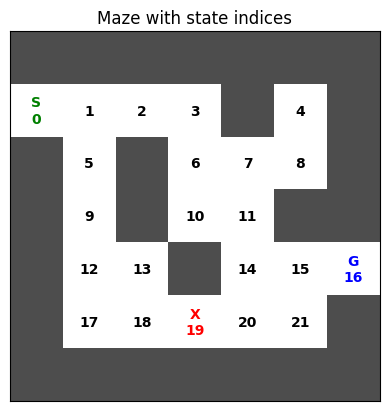

In [8]:
def plot_maze_with_states() -> None:
    """Plot the maze with state indices."""
    grid = np.ones(
        (n_rows, n_cols),
    )  # Start with a matrix of ones. Here 1 means “free cell”
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                grid[i, j] = 0  # We replace walls (#) with 0

    _fig, ax = plt.subplots()
    ax.imshow(grid, cmap="gray", alpha=0.7)

    # Plot state indices
    for (
        s,
        (i, j),
    ) in state_to_pos.items():
        cell = maze_str[i][j]

        if cell == "S":
            label = f"S\n{s}"
            color = "green"
        elif cell == "G":
            label = f"G\n{s}"
            color = "blue"
        elif cell == "X":
            label = f"X\n{s}"
            color = "red"
        else:
            label = str(s)
            color = "black"

        ax.text(
            j,
            i,
            label,  # Attention : matplotlib, text(x, y, ...) expects (column, row)
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color=color,
        )

    ax.set_xticks([])  # remove numeric axes, we don't need.
    ax.set_yticks([])
    ax.set_title("Maze with state indices")

    plt.show()


plot_maze_with_states()


### 2.4 Actions and deterministic movement

We first define integer codes for each action. 

**Exercise 3.** How many possible actions can the agent take in the maze?

We have four possible actions in the maze. 

In this following cell, each action is mapped to an integer (0,1,2,3). This makes it easy to store and use actions inside arrays and matrices

Here we use Unicode arrow character:

- "\u2191" : ↑ (up arrow)

- "\u2192" : → (right arrow)

- "\u2193" : ↓ (down arrow)

- "\u2190" : ← (left arrow)

In [9]:
A_UP, A_RIGHT, A_DOWN, A_LEFT = 0, 1, 2, 3
ACTIONS = [A_UP, A_RIGHT, A_DOWN, A_LEFT]
action_names = {A_UP: "\u2191", A_RIGHT: "\u2192", A_DOWN: "\u2193", A_LEFT: "\u2190"}

In [10]:
print(action_names[0])

↑


**Exercise 4.** Now we define a **deterministic movement function** `move_deterministic(i, j, a)`. 

This function simulates the robot trying to move from (i, j) in direction a.

But if the movement hits a wall or boundary, the agent stays in place.

**Complete the `# !!TO DO HERE !!` part in the program below.**

In [11]:
def move_deterministic(i: int, j: int, a: int) -> tuple[int, int]:
    """Deterministic movement on the grid. If the movement hits a wall or boundary, the agent stays in place.

    Args:
        i (int): current row index
        j (int): current column index
        a (int): action to take (A_UP, A_DOWN, A_LEFT, A_RIGHT)

    Returns:
        (tuple[int, int]): new (row, column) position after taking action a

    """
    candidate_i, candidate_j = (
        i,
        j,
    )  # It means “Unless the action succeeds, the robot stays in place.”

    # Now each action changes the coordinates of the robot:
    if a == A_UP:
        candidate_i, candidate_j = (
            i - 1,
            j,
        )  # if the action is UP, then row becomes row -1
    elif a == A_DOWN:
        candidate_i, candidate_j = (
            i + 1,
            j,
        )  # if the action is DOWN, then row becomes row +1
    elif a == A_LEFT:
        candidate_i, candidate_j = (
            i,
            j - 1,
        )  # if the action is LEFT, then column becomes column -1
    elif a == A_RIGHT:
        candidate_i, candidate_j = (
            i,
            j + 1,
        )  # if the action is RIGHT, then column becomes column +1

    # Check boundaries
    if not (0 <= candidate_i < n_rows and 0 <= candidate_j < n_cols):
        # If the robot tries to move outside the maze
        # It will not move and it stays at (i, j).
        return i, j

    # Check wall
    if maze_str[candidate_i][candidate_j] == "#":
        # If the next cell is a wall, the robot stays in place.
        return i, j

    return candidate_i, candidate_j  # Otherwise, return the new position


### 2.5 Transition probabilities and reward function

Recall that we set the discount factor $\gamma \in(0,1)$, that is, the future rewards are multiplied by $\gamma$, so immediate rewards matter a little bit more than future ones. 


Moreover, we consider a probability error $p_{\text{error}}$, which means, with probability $p_{\text{error}}$, the robot **does not** execute the intended action but one of the 3 other directions (chosen uniformly). With probability $1-p_{\text{error}}$, the robot executes the action that we asked.

In [12]:
gamma = 0.95
p_error = 0.1  # probability of the error to a random other direction


Now we initialize the state–transition probability : the probability of reaching next state $s'$ after taking action $a$ in state $s$. 
$$
        p(s' \mid s, a)
        = \mathbb{P} \big[S_t=s'\,|\, S_{t-1}=s, \,A_{t-1}=a\big]
$$

We store these transition probabilities in the 3D array `P` (`P[a][s, s_next]`), which has shape `(n_actions, n_states, n_states)`:

`P[a, s, s_next] = P(S_{t+1} = s_next | S_t = s, A_t = a)`.

We also initialize the reward vector `R`, which has length `n_states`, where `R[s]` is the reward received when the agent is in state `s`.

In this maze game, we assume that the reward depends only on the current state, which is natural: in navigation tasks, being in a particular location is what matters, not the direction you used to reach it.

In [13]:
# Initialize transition matrices and reward vector
P = np.zeros((len(ACTIONS), n_states, n_states))
R = np.zeros(n_states)

Now we assign the reward to each state. 

For each state index s:

1. If s is a goal, then the reward = +1.0
2. If s is a trap, then the reward = −1.0
3. Otherwise for the normal cell, the reward = −0.01 every time you leave this cell.

Recall that rewards are received at the moment the agent executes an action. Here when the agent moves out of the cell, we set reward −0.01. 

In [14]:
# Set rewards for each state
step_penalty = -0.01
goal_reward = 1.0
trap_reward = -1.0

**Exercise 5.** Why do we set the step penalty to -0.01 in this MDP?

**Solution 5** We assign a small negative reward for every step, which encourages the agent to reach the goal quickly.


**Exercise 6.** We now define the reward vector. Recall that we have already initialized
`R = np.zeros(n_states)`.
If a state belongs to `goal_states`, we assign the `goal_reward`.
If it belongs to `trap_states`, we assign the `trap_reward`.
Otherwise, we assign the `step_penalty`. 

**Complete the `# TO DO` part in the program below.** 

In [15]:
for s in range(n_states):
    if s in goal_states:
        R[s] = goal_reward
    elif s in trap_states:
        R[s] = trap_reward
    else:
        R[s] = step_penalty

Now we define terminal states and a helper function. Here terminal_states is a set containing all absorbing states, which means, reaching them ends the episode conceptually. 

Moreover, `is_terminal(s)` is a small helper to check if a state is terminal.

In [16]:
terminal_states = set(goal_states + trap_states)


def is_terminal(s: int) -> bool:
    """Check if a state is terminal."""
    return s in terminal_states


Now we need to fill the transition matrices `P[a][s, s_next]`. 


**Exercise 7.** **Complete the `# TO DO` part in the program below** to fill the transition matrices `P[a][s, s_next]`. (There are only 2 # TO DO here)

In [17]:
for s in range(n_states):  # We loop over all states s.
    i, j = state_to_pos[
        s
    ]  # We recover the states to their coordinates (i, j) in the maze.

    # First, in a goal or trap state,
    # No matter which action you “choose”, you stay in the same state with probability 1.
    # This makes the terminal states as the absorbing states.
    if is_terminal(s):
        # Terminal states: stay forever
        for a in ACTIONS:
            P[a, s, s] = goal_reward
        continue

    # If the state is non-terminal, we define the stochastic movement.
    # For a given state s and intended action a,
    # With probability 1 - p_error, the robot will move in direction a;
    # With probability p_error, the robot will move in one of the other 3 directions, each with probability p_error / 3.
    for a in ACTIONS:
        # main action (intended action)
        main_i, main_j = move_deterministic(i, j, a)
        s_main = pos_to_state[
            (main_i, main_j)
        ]  # s_main is the state index of that next cell.
        P[a, s, s_main] += (
            1 - p_error
        )  # We add probability 1 - p_error to P[a, s, s_main].

        # error actions
        other_actions = [
            a2 for a2 in ACTIONS if a2 != a
        ]  # other_actions = the 3 actions different from a.
        for a2 in other_actions:  # for each of the error action,
            error_i, error_j = move_deterministic(i, j, a2)
            s_error = pos_to_state[(error_i, error_j)]  # get its state index s_error
            P[a, s, s_error] += p_error / len(
                other_actions,
            )  # add p_error / 3 to P[a, s, s_error]
# So for each (s,a), probabilities over all s_next sum to 1.


Now we check if the transition matrices `P[a][s, s_next]` are computed correctly.
For each action `a`, we sum the transition probabilities over all possible next states `s_next` and verify that these sums are equal to 1.

This is because the matrix `P[a, s, s_next]` stores the transition probability

$\mathbb{P} \big[S_t=s_{\text{next}}\,|\, S_{t-1}=s, \,A_{t-1}=a\big]$. 

Therefore, for each action $a$, and for each state $s$, the sum over $s_{\text{next}}$ of $\mathbb{P} \big[S_t=s_{\text{next}}\,|\, S_{t-1}=s, \,A_{t-1}=a\big]$ should be 1. 

In [18]:
for a in ACTIONS:
    # For each action a:
    # P[a] is a matrix of shape (n_states, n_states).
    # P[a].sum(axis=1) sums over next states s_next, giving for each state s:
    # We print these row sums.
    # If everything is correct, they should be very close to 1.

    probs = P[a].sum(axis=1)
    print(f"Action {action_names[a]}:", probs)


Action ↑: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action →: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ↓: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Action ←: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Policy evaluation

### 3.1 Bellman expectation equation

Recall that the value function under a policy $\pi$ is defined as:
$$
V^{\pi}(s)=\mathbb{E}\Big[\:G_t \:\Big|\: S_t=s\:\Big]
$$
where the return $G_t$ is
$$
G_t=R_t +\gamma R_{t+1}+\gamma^2 R_{t+2}+... . 
$$
This means *The value of a state is the expected discounted sum of all future rewards
when following policy $\pi$.*

We know that $G_t=R_t+\gamma G_{t+1}$, and plugging this equation into the definition of $V^{\pi}(s)$, we get 
$$
V^{\pi}(s)=\mathbb{E}\Big[\:R_t \:\Big|\: S_t=s\:\Big]+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s\:\Big]. 
$$
This step shows simply ``The total future reward = immediate reward + discounted reward from next state.''

For the expected immediate reward part $\mathbb{E}[R_t| S_t=s]$, as we are in a maze problem, the reward depends only on the current state, not the time step, i.e., $\mathbb{E}[R_t| S_t=s]=R(s)$. Hence we get 
$$
V^{\pi}(s)=R(s)+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s\:\Big]. 
$$

Moreover, in this maze problem, we consider a deterministic policy $A_t=\pi(s)$ (the action depends only on the state). Therefore, 
$$
V^{\pi}(s)=\mathbb{E}\Big[\:R_t \:\Big|\: S_t=s\:\Big]+\gamma\mathbb{E}\Big[\:G_{t+1} \:\Big|\: S_t=s, A_t=\pi(s)\:\Big]. 
$$

Now **given the state $S_t=s$ and $A_t=a$**, the next state is random (because of the error probability) and we know the transition probability 
$$
\mathbb{P}\big(\:S_{t+1}=s' \:|\:S_t=s, \, A_t=a\big)=P\big(s'\:\big|\:s, a\big). 
$$

Therefore,
$$
\mathbb{E}\big[\,G_{t+1}\,|\,S_t=s,A_t=a\,\big] =\sum_{s'}\mathbb{E}\big[\,G_{t+1}\,|\,S_{t+1}=s'\,\big]\times \mathbb{P}\big[S_{t+1}=s'\,\big|\,S_t=s, A_t=a\, \big]
$$
$$
\hspace{-1.2cm}=\sum_{s'}V^{\pi}(s')P\big(s'\:\big|\:s, a\big),
$$
where here we use the Markov property. (**Question: Can you show the detailed computations here?**)

In conclusion, we have (the Bellman expectation equation)
$$
V^{\pi}(s)=R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}(s').
$$

### 3.2 Define a function which computes the value function $V^{\pi}(s)$ for a given deterministic policy. 


**Exercise $8^*$.** Now we define `policy_evaluation(...)`, which computes the value function $V^{\pi}(s)$ for a given deterministic policy. 

The input of this function `policy_evaluation(...)` are:
1. policy: array of size `n_states`, each entry is an action 0,1,2,3, which correspond to UP, RIGHT, DOWN, LEFT.
2. `P`: the transition probabilities `P[a, s, s']`.
3. `R`: the reward vector `R[s]`.
4. gamma: the discount factor $\gamma\in(0,1)$.
5. theta: convergence threshold.
6. max_iter: which is used to avoid infinite loops.

How can we apply the Bellman expectation equation
$$
V^{\pi}(s)=R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}(s').
$$
here ?



We start with an initial guess of $V^{\pi}$(e.g., all values = 0) and repeatedly apply the Bellman equation to update each state:
$$
V_{k+1}^\pi(s) \leftarrow R(s)+\gamma \sum_{s'}P\big(\,s'\,\big|\,s, \pi(s)\,\big)V^{\pi}_k(s').
$$
until values converge.

**Complete the `# TO DO HERE` part in the program below** 

In [19]:
def policy_evaluation(  # noqa: PLR0913
    policy: np.ndarray,
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 10_000,
) -> np.ndarray:
    """Evaluate a deterministic policy for the given MDP.

    Args:
        policy: array of shape (n_states,), with values in {0,1,2,3}
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold
        max_iter: maximum number of iterations

    """
    n_states = len(R)  # get the number of states
    V = np.zeros(n_states)  # initialize the value function

    for _it in range(max_iter):  # Main iterative loop
        V_new = np.zeros_like(
            V,
        )  # Create a new value vector and we will compute an updated value for each state.

        # Now we update each state using the Bellman expectation equation
        for s in range(n_states):
            a = policy[s]  # Extract the action chosen by the policy in state
            V_new[s] = R[s] + gamma * np.sum(P[a, s, :] * V)

        delta = np.max(
            np.abs(V_new - V),
        )  # This measures how much the value function changed in this iteration:
        # If delta is small, the values start to converge; otherwise, we need to keep iterating.
        V = V_new  # Update V, i.e. Set the new values for the next iteration.

        if delta < theta:  # Check convergence: When changes are tiny, we stop.
            break

    return V  # Return the final value function, this is our estimate for V^{pi}(s), s in the state set.


### 3.3 Evaluating a random policy

Now we use the policy evaluation function `policy_evaluation` to evaluate a random policy. 

We first generate a `random_policy`, which is an array like [2, 0, 1, 3, 0, 2, ...] and has the size `n_states`. (Recall that the policy is a mapping from states to actions).

In [20]:
# Random policy: for each state, pick a random action
random_policy = rng.integers(low=0, high=len(ACTIONS), size=n_states)

print(random_policy)

[0 3 2 1 1 3 0 2 0 0 2 3 2 3 2 3 2 0 3 1 2 1]


Now we call the function `policy_evaluation(...)` to compute $V^{\pi_{\text{random}}}(s)$.

In [21]:
V_random = policy_evaluation(random_policy, P, R, gamma)
print("Value function under random policy:")
print(V_random)

Value function under random policy:
[ -0.2    -0.2    -0.201  -0.204  -0.205  -0.202  -0.214  -0.429  -0.212
  -0.207  -0.276  -0.459  -0.352  -0.366  -5.827  -4.605  20.     -0.366
  -0.999 -20.     -6.4    -3.163]


Here in this value vector of the policy, 
- If it is a negative values, then the agent tends to move around aimlessly, fall in traps, or take too long.
- It it is a higher values, then the agent is closer to the goal or more likely to reach it

Now we define a function `plot_values`, which displays the value function $V(s)$ and displays it on the maze grid. It helps students visually understand:
- which states are good (high value, near the goal),
- which states are bad (low value, near traps),
- how a policy affects the long-term expected reward.

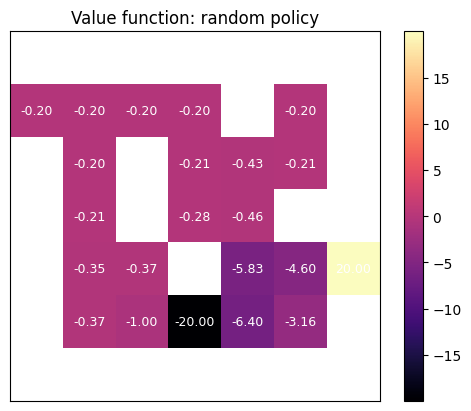

In [22]:
def plot_values(V: np.ndarray, title: str = "Value function") -> None:
    """Plot the value function V on the maze as a heatmap."""
    grid_values = np.full(
        (n_rows, n_cols),
        np.nan,
    )  # Initializes a grid the same size as the maze. Every cell starts as NaN.
    for (
        s,
        (i, j),
    ) in (
        state_to_pos.items()
    ):  # recall that state_to_pos maps each state index to its maze coordinates (i,j).
        grid_values[i, j] = V[
            s
        ]  # For each reachable cell, we write the value V[s] in the grid.
        # Walls # never get values, and they stay as NaN.

    _fig, ax = plt.subplots()
    im = ax.imshow(grid_values, cmap="magma")
    plt.colorbar(im, ax=ax)

    # For each state:
    # Place the text label at (column j, row i).
    # Display value to two decimals.
    # Use white text so it's visible on the heatmap.
    # Center the text inside each cell.

    for s, (i, j) in state_to_pos.items():
        ax.text(
            j,
            i,
            f"{V[s]:.2f}",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
        )

    # Remove axis ticks and set title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()


plot_values(V_random, title="Value function: random policy")


The next function `plot_policy` visualizes a policy on the maze.


In [23]:
def plot_policy(policy: np.ndarray, title: str = "Policy") -> None:
    """Plot the given policy on the maze."""
    _fig, ax = plt.subplots()
    # draw walls as dark cells
    wall_grid = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            if maze_str[i][j] == "#":
                wall_grid[i, j] = 1
    ax.imshow(wall_grid, cmap="Greys", alpha=0.5)

    for s, (i, j) in state_to_pos.items():
        cell = maze_str[i][j]
        if cell == "#":
            continue

        if s in goal_states:
            ax.text(
                j,
                i,
                "G",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="blue",
            )
        elif s in trap_states:
            ax.text(
                j,
                i,
                "X",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="red",
            )
        elif s == start_state:
            ax.text(
                j,
                i,
                "S",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color="green",
            )
        else:
            a = policy[s]
            ax.text(
                j,
                i,
                action_names[a],
                ha="center",
                va="center",
                fontsize=14,
                color="black",
            )

    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(visible=True)
    ax.set_title(title)
    plt.show()


Now let’s visualize the `random_policy`. Does it seem like a good policy?

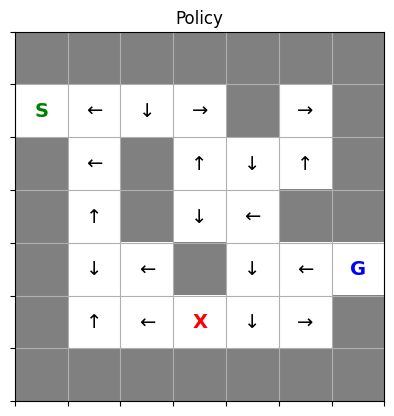

In [24]:
plot_policy(random_policy, title="Policy")

**Exercise 9.** Define your own policy and evaluate it using the functions `policy_evaluation(...)` and `plot_values(...)`. **Can you identify an optimal policy visually?**  Plot your own policy using `plot_policy`. 


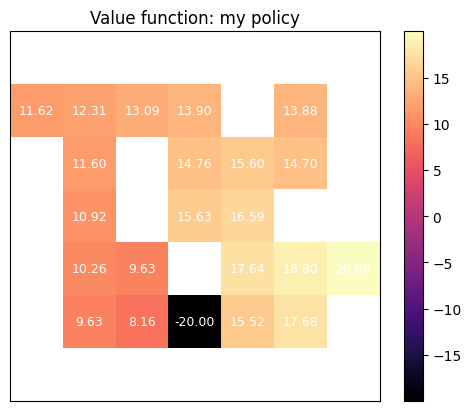

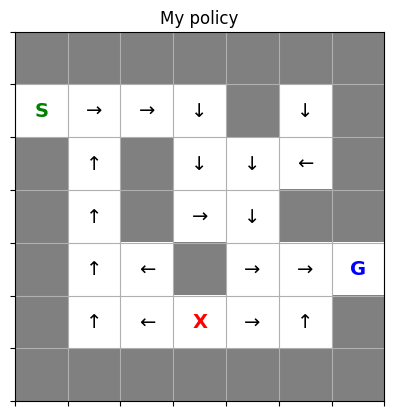

In [25]:
my_policy = np.array(
    [
        A_RIGHT,
        A_RIGHT,
        A_RIGHT,
        A_DOWN,
        A_DOWN,  # First row
        A_UP,
        A_DOWN,
        A_DOWN,
        A_LEFT,  # Second row
        A_UP,
        A_RIGHT,
        A_DOWN,  # Third row
        A_UP,
        A_LEFT,
        A_RIGHT,
        A_RIGHT,
        A_RIGHT,  # Fourth row
        A_UP,
        A_LEFT,
        A_DOWN,
        A_RIGHT,
        A_UP,  # Fifth row
    ],
)

V_my_policy = policy_evaluation(policy=my_policy, P=P, R=R, gamma=gamma)

plot_values(V=V_my_policy, title="Value function: my policy")
plot_policy(policy=my_policy, title="My policy")


-----------------------------------

## 4. Dynamic programming : Policy improvement and Policy iteration

**Exercise 12.**  

Write a `policy_improvement` function whose inputs are the state-value function `V`, the transition probability matrix `P`, the reward vector `R`, and the discount factor $\gamma$.  
The function should return a **greedy policy** that, for each state, selects the action that maximizes the expected return according to the input `V`.


*Question: Why don’t we input the old policy in this policy improvement step?*


*Remark.* In this maze game, we consider a deterministic policy $\pi:s\in\mathcal{S}\mapsto a\in\mathcal{A}$ that assigns one single action to each state.


------------------

*Hint.* 1. This exercise can be completed in two steps.  

In the first step, compute the action-value function $q^{\pi}(s,a)$ from the state-value function $s' \mapsto v^{\pi}(s') $, for a fixed state $ s $.  
Which formula should be used to express $ q^{\pi}(s,a) $ in terms of $ v^{\pi} $?

In the second step, perform the greedy policy improvement step by computing a new policy $ \pi' $ such that
$$
\pi'(s) = \arg\max_{a} q^{\pi}(s,a).
$$

Attention, for terminal states, action choice is irrelevant, we can set 0 to terminal states. 

2. Bellman action-value equation for the maze: 

In this maze environment, the **immediate reward depends only on the current state (for non-terminal state)**:

$$
r(s,a,s') = R(s).
$$

This means:

- The reward does **not** depend on the action taken.
- The reward does **not** depend on the next state.
- All actions taken from the same state yield the same immediate reward.

The general Bellman equation for the action-value function is:

$$
Q(s,a)
=
\sum_{s', r} P(s',r\mid s,a)
\left(
r(s,a,s') + \gamma V(s')
\right).
$$

Since the reward satisfies  
$$
r(s,a,s') = R(s),
$$
we can simplify the expression:

$$
\begin{aligned}
Q(s,a)
&= \sum_{s'} P(s' \mid s,a)
\left(
R(s) + \gamma V(s')
\right) \\
&= R(s) + \gamma \sum_{s'} P(s' \mid s,a) V(s').
\end{aligned}
$$



In [26]:
def policy_improvement(
    V: np.ndarray,
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
) -> np.ndarray:
    """Given a value function V, output a greedy policy.

    Args:
        V: array of shape (n_states,)
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor

    Returns:
        policy: array of shape (n_states,), with values in {0,1,2,3}
        n_states = len(R)

    """
    n_actions = P.shape[0]
    policy = np.zeros(
        n_states,
        dtype=int,
    )

    for s in range(n_states):
        if is_terminal(s):
            policy[s] = 0
            continue

        Q_values = np.zeros(n_actions)
        for a in range(n_actions):
            Q_values[a] = R[s] + gamma * np.dot(
                P[a, s, :],
                V,
            )
        policy[s] = int(
            np.argmax(Q_values),
        )
    return policy


**Exercise 13.**  

Write a `policy_iteration` function whose inputs are the initial policy `initial_policy`, the transition probability matrix `P`, the reward vector `R`, the discount factor $\gamma$ `gamma`, the tolerance parameter `theta` used in policy evaluation (the evaluation stops when the value function changes by less than `theta`), and `max_iter`, which serves as a safety limit to prevent the loop from running indefinitely.  

The function should return two outputs:  
- `policy`, the final (optimal) policy, represented as an array of action indices;  
- `V`, the value function corresponding to this policy.



--------------------------

*Hint.* The `policy_iteration` algorithm consists of two main steps.  
First, the **policy evaluation** step, where you will use the function implemented in **Exercise 8**.  
Second, the **policy improvement** step, where you will use the function implemented in **Exercise 12**.

--------------------------

In [27]:
def policy_iteration(  # noqa: PLR0913
    initial_policy: np.ndarray,
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 1000,
) -> tuple[np.ndarray, np.ndarray]:
    """Policy Iteration.

    Goal:
        Learn an optimal policy by alternating:
        1) Policy Evaluation
        2) Policy Improvement

    Inputs:
        initial_policy : array of shape (num_states,)
            Initial deterministic policy.
        P : transition probabilities
        R : reward function
        gamma : discount factor
        theta : stopping threshold for policy evaluation
        max_iter : maximum number of policy iteration steps

    Returns:
        policy : optimal policy
        V : value function of the optimal policy

    """
    policy = initial_policy

    for _it in range(max_iter):
        V = policy_evaluation(policy, P, R, gamma, theta)
        new_policy = policy_improvement(V, P, R, gamma)
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy
    return policy, V


**Exercise 14.**  

Starting from a random policy (see Section 3.3), compute an optimal policy for the Maze game.  
Then, plot the value function of this optimal policy and visualize the policy itself by displaying arrows on the maze.


[0 3 3 2 1 3 2 1 1 0 0 2 3 0 3 3 1 2 0 3 2 1]
[1 1 1 2 2 0 2 2 3 0 1 2 0 3 1 1 0 0 0 0 1 0]
Optimal value function:
[ 11.62   12.311  13.095  13.901  13.875  11.596  14.756  15.6    14.699
  10.921  15.631  16.589  10.263   9.633  17.643  18.804  20.      9.633
   8.156 -20.     15.522  17.679]


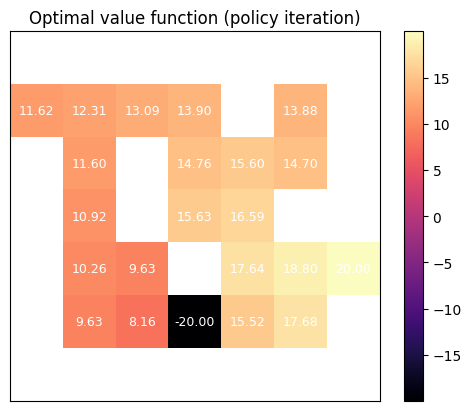

In [28]:
random_policy = rng.integers(low=0, high=len(ACTIONS), size=n_states)
print(random_policy)

opt_policy, V_opt = policy_iteration(
    random_policy,
    P,
    R,
    gamma,
    theta=1e-6,
    max_iter=1000,
)
print(opt_policy)
print("Optimal value function:")
print(V_opt)

plot_values(V_opt, title="Optimal value function (policy iteration)")
plot_policy(opt_policy, title="Optimal policy (policy iteration)")


## 5. Dynamic programming : Value iteration

**Exercise 15.**  Write a `value_iteration` function whose inputs are the transition probability matrix `P`, the reward vector `R`, the discount factor $\gamma$ `gamma`, the parameter `theta`, which is a stopping tolerance (stop when the value function changes by less than theta), and `max_iter`, which serves as a safety limit to prevent the loop from running indefinitely.  

The outputs of value_iteration are `V`, which is an approximation of the optimal value function, and `policy`, which is a greedy policy derived from the final `V`.

*Question:* Do `value_iteration` and `policy_iteration` find the same optimal policy?

*Hint.* Value iteration repeatedly applies the Bellman optimality operator. In the maze case, it is 
$$
(\mathcal{T}^* V)(s)=\max_a \Big\{ R(s) + \gamma \sum_{s'}P(s'|s,a)V(s')\Big\}
$$

In [29]:
def value_iteration(
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 10_000,
) -> tuple[np.ndarray, np.ndarray]:
    """Value Iteration (student version).

    Goal:
        Approximate the optimal value function V*
        and derive an optimal policy.

    Inputs:
        P : array of shape (n_actions, n_states, n_states)
            Transition probabilities.
        R : array of shape (n_states,)
            Reward for each state.
        gamma : float
            Discount factor.
        theta : float
            Stopping tolerance for convergence.
        max_iter : int
            Maximum number of iterations.

    Returns:
        V : array of shape (n_states,)
            Approximation of the optimal value function V*.
        policy : array of shape (n_states,)
            Greedy policy derived from V.

    """
    n_states = len(R)
    n_actions = P.shape[0]
    V = np.zeros(n_states)

    for _it in range(max_iter):
        V_new = np.zeros_like(V)

        for s in range(n_states):
            if is_terminal(s):
                V_new[s] = R[s] / (1 - gamma)
                continue

            Q_values = np.zeros(
                n_actions,
            )
            for a in range(n_actions):
                Q_values[a] = R[s] + gamma * np.dot(P[a, s, :], V)
            V_new[s] = np.max(Q_values)

        delta = np.max(np.abs(V_new - V))
        V = V_new
        if delta < theta:
            break

    policy = policy_improvement(
        V,
        P,
        R,
        gamma,
    )
    return V, policy


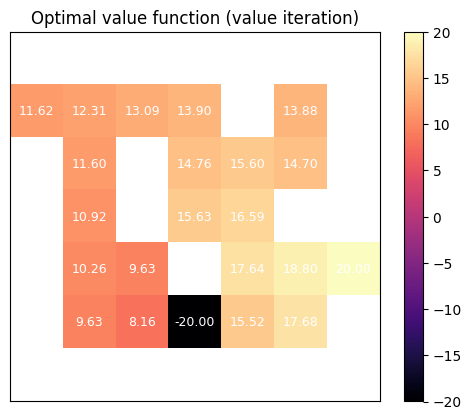

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
V_vi, policy_vi = value_iteration(P, R, gamma)

plot_values(V_vi, title="Optimal value function (value iteration)")
plot_policy(policy_vi, title="Optimal policy (value iteration)")

print(np.abs(opt_policy - policy_vi))


## 6. Advanced exercises 



**Exercise 16 (Policy Iteration vs Value Iteration)**

In this exercise, we compare the number of iterations required by **policy iteration** and **value iteration** to reach an optimal policy in the Maze game.

1. Modify the definition of `policy_iteration` and `value_iteration` so that they can record:
   - the **number of iterations** until convergence,
   - and optionally the runtime.
2. Run both algorithms starting from:
   - the same random initialization (a random policy for policy iteration, and $V_0 \equiv 0$ for value iteration),
   - and repeat the experiment over several random seeds in order to compute the **average number of iterations** and **average runtime**.
3. Report and interpret the results.

*Question:* What do you observe?

-------------

*Hint.* the word “iteration” means something different for **policy iteration** and **value iteration**:

- Policy iteration: one “iteration” = one outer loop step = policy evaluation + policy improvement.
- Value iteration: one “iteration” = one Bellman optimality sweep over all states.

-------------


In [31]:
import time


def policy_iteration_count(  # noqa: PLR0913
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 1_000,
    seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, int, float]:
    """Policy Iteration that counts the number of outer iterations and runtime.

    Args:
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold for policy evaluation
        max_iter: maximum number of outer iterations
        seed: random seed for initial policy

    Returns:
        policy: optimal policy found
        V: value function of the optimal policy
        n_iterations: number of outer iterations until convergence
        runtime: total runtime in seconds

    """
    rng = np.random.default_rng(
        seed,
    )
    n_states = len(R)
    n_actions = P.shape[0]

    policy = rng.integers(
        low=0,
        high=n_actions,
        size=n_states,
    )

    t0 = time.perf_counter()

    for it in range(max_iter):
        V = policy_evaluation(
            policy,
            P,
            R,
            gamma,
            theta=theta,
        )

        new_policy = policy_improvement(
            V,
            P,
            R,
            gamma,
        )

        if np.array_equal(
            new_policy,
            policy,
        ):
            runtime = time.perf_counter() - t0
            return (
                policy,
                V,
                it + 1,
                runtime,
            )

        policy = new_policy

    runtime = time.perf_counter() - t0
    return (
        policy,
        V,
        max_iter,
        runtime,
    )


def value_iteration_count(
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 100_000,
) -> tuple[np.ndarray, np.ndarray, int, float]:
    """Value Iteration that counts the number of iterations and runtime.

    Args:
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold
        max_iter: maximum number of iterations

    Returns:
        V: array of shape (n_states,)
            Approximation of the optimal value function V*.
        policy: array of shape (n_states,)
            Greedy policy derived from V.
        n_iterations: number of iterations until convergence
        runtime: total runtime in seconds

    """
    n_states = len(R)
    n_actions = P.shape[0]

    V = np.zeros(n_states)
    t0 = time.perf_counter()

    for it in range(max_iter):
        V_new = np.zeros_like(V)

        for s in range(n_states):
            if is_terminal(s):
                V_new[s] = R[s] / (1 - gamma)
                continue

            Q = np.zeros(n_actions)
            for a in range(n_actions):
                Q[a] = R[s] + gamma * np.dot(P[a, s, :], V)
            V_new[s] = np.max(Q)

        delta = np.max(np.abs(V_new - V))
        V = V_new

        if delta < theta:
            runtime = time.perf_counter() - t0
            policy = policy_improvement(V, P, R, gamma)
            return (
                V,
                policy,
                it + 1,
                runtime,
            )

    runtime = time.perf_counter() - t0
    policy = policy_improvement(
        V,
        P,
        R,
        gamma,
    )
    return (
        V,
        policy,
        max_iter,
        runtime,
    )


# Next, run the comparison over several seeds
gamma = 0.9
theta = 1e-6
seeds = list(range(10))

pi_iters = []
vi_iters = []
pi_times = []
vi_times = []

for seed in seeds:
    pi_policy, pi_V, n_pi, t_pi = policy_iteration_count(  # noqa: N816
        P,
        R,
        gamma,
        theta=theta,
        seed=seed,
    )
    vi_V, vi_policy, n_vi, t_vi = value_iteration_count(P, R, gamma, theta=theta)  # noqa: N816

    pi_iters.append(n_pi)
    vi_iters.append(n_vi)
    pi_times.append(t_pi)
    vi_times.append(t_vi)

    print("Same policy?", np.array_equal(pi_policy, vi_policy))


print("Policy Iteration - outer iterations:", pi_iters)
print("Value Iteration  - iterations:", vi_iters)

print("Mean PI iterations:", np.mean(pi_iters))
print("Mean VI iterations:", np.mean(vi_iters))
print("Mean PI runtime:", np.mean(pi_times))
print("Mean VI runtime:", np.mean(vi_times))


Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Same policy? True
Policy Iteration - outer iterations: [3, 3, 2, 3, 4, 3, 3, 3, 3, 4]
Value Iteration  - iterations: [34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
Mean PI iterations: 3.1
Mean VI iterations: 34.0
Mean PI runtime: 0.033542495701112784
Mean VI runtime: 0.007521004001318943


**Exercise 17.** (Asynchronous Value Iteration)

Implement asynchronous value iteration, where the value function is updated in place :
$$
V(s) \leftarrow \max_a\left\{R(s)+\gamma \sum_{s'}P(s'|s,a)V(s')\right\}.
$$

Compare the number of iterations needed for convergence with the synchronous version.

-------------------

Hint. Synchronous value iteration uses a copy `V_new` and updates all states from the old `V`. Asynchronous value iteration updates `V[s]` immediately, so later states in the same sweep can use the newest values.

-------------------



In [32]:
def asynchronous_value_iteration(
    P: np.ndarray,
    R: np.ndarray,
    gamma: float,
    theta: float = 1e-6,
    max_iter: int = 200_000,
) -> tuple[np.ndarray, np.ndarray, int]:
    """Asynchronous Value Iteration.

    Args:
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor
        theta: convergence threshold
        max_iter: maximum number of iterations

    Returns:
        V: array of shape (n_states,)
            Approximation of the optimal value function V*.
        policy: array of shape (n_states,)
            Greedy policy derived from V.
        n_iterations: number of iterations until convergence

    """
    n_states = len(R)
    n_actions = P.shape[0]
    V = np.zeros(n_states)

    for _it in range(max_iter):
        delta = 0.0

        for s in range(n_states):
            v_old = V[s]

            if is_terminal(s):
                V[s] = R[s] / (1 - gamma)
            else:
                Q = np.zeros(n_actions)
                for a in range(n_actions):
                    Q[a] = R[s] + gamma * np.dot(P[a, s, :], V)
                V[s] = np.max(Q)

            delta = max(
                delta,
                abs(V[s] - v_old),
            )

        if delta < theta:
            break

    pi = policy_improvement(V, P, R, gamma)
    return V, pi, _it + 1


gamma = 0.9
V_sync, pi_sync = value_iteration(P, R, gamma, theta=1e-6)
V_async, pi_async, it_async = asynchronous_value_iteration(P, R, gamma, theta=1e-6)


print("Same policy?", np.array_equal(pi_sync, pi_async))
print("Async iterations:", it_async)


Same policy? True
Async iterations: 22


**Exercise 18.** (Bellman Optimality Operator)

Show numerically that the Bellman optimality operator $\mathcal{T}^*$ satisfies the contraction property, which means, for arbitrary value functions $V$ and $W$, we have 
$$
\big\Vert  \mathcal{T}^* V - \mathcal{T}^* W \big\Vert_{\infty}\leq \gamma \Vert V-W\Vert_{\infty}
$$

---------------

*Hint.* Generate random value functions $V$ and $W$, apply one Bellman optimality update to each, and compare both sides of the inequality.

---------------

In [33]:
def T_opt(V: np.ndarray, P: np.ndarray, R: np.ndarray, gamma: float) -> np.ndarray:
    """Compute the optimal Bellman operator T^* applied to V.

    Args:
        V: array of shape (n_states,)
        P: array of shape (n_actions, n_states, n_states)
        R: array of shape (n_states,)
        gamma: discount factor

    Returns:
        out: array of shape (n_states,)

    """
    n_states = len(R)
    n_actions = P.shape[0]
    out = np.zeros(n_states)

    for s in range(n_states):
        if is_terminal(s):
            out[s] = R[s] / (1 - gamma)
        else:
            Q = np.zeros(n_actions)
            for a in range(n_actions):
                Q[a] = R[s] + gamma * np.dot(P[a, s, :], V)
            out[s] = np.max(Q)

    return out


def sup_norm(x: np.ndarray) -> float:
    """Compute the sup norm (infinity norm) of vector x."""
    return np.max(np.abs(x))


gamma = 0.9
n_states = len(R)
rng = np.random.default_rng()

num_tests = 50
fails_numbers = 0

for _ in range(num_tests):
    V = rng.standard_normal(n_states)
    W = rng.standard_normal(n_states)

    lhs = sup_norm(T_opt(V, P, R, gamma) - T_opt(W, P, R, gamma))
    rhs = gamma * sup_norm(V - W)

    if lhs > rhs + 1e-10:
        fails_numbers += 1

print("fails:", fails_numbers, "out of", num_tests)

fails: 0 out of 50


**Exercise 19** (Effect of the Discount Factor)

Recall that the discount factor controls how future rewards are weighted relative to immediate rewards. Run value iteration for different values of the discount factor $\gamma\in\{0.2, 0.5, 0.9, 0.99\}$. 

For each value of $\gamma$: 

1. Compute the optimal value function $V^*$.
2. Compute the corresponding optimal policy.
3. Plot the value function and visualize the policy on the maze.


gamma=0.2: computed V* and pi*


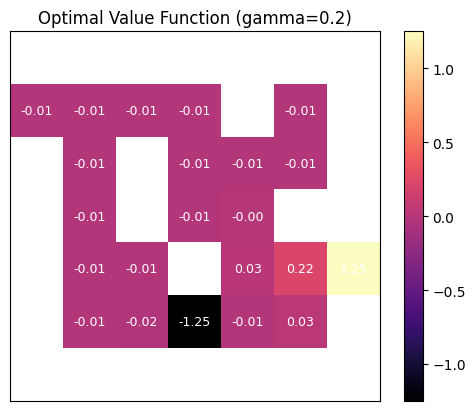

gamma=0.5: computed V* and pi*


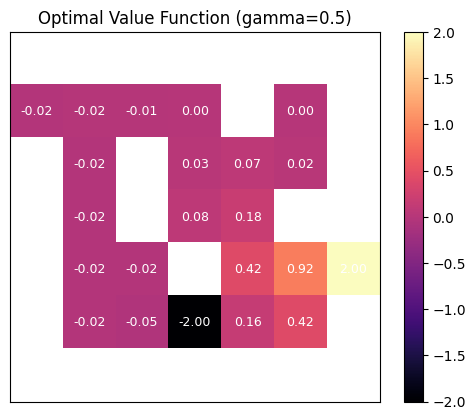

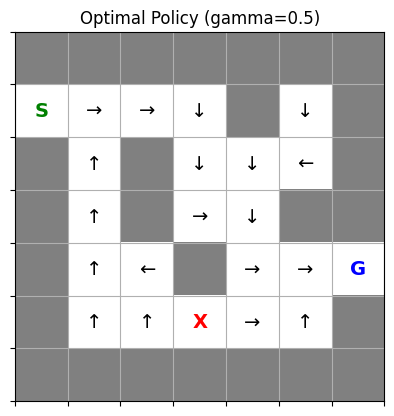

gamma=0.9: computed V* and pi*


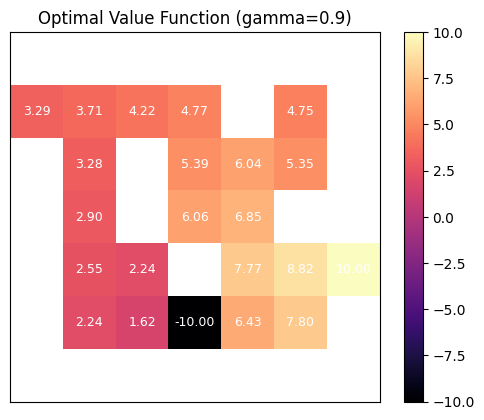

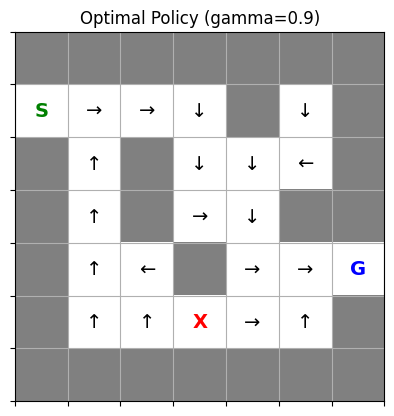

gamma=0.99: computed V* and pi*


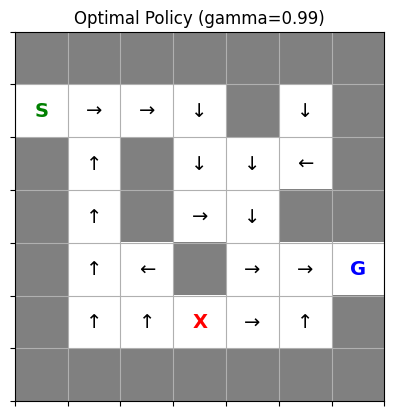

In [34]:
gammas = [0.2, 0.5, 0.9, 0.99]
theta = 1e-6

results = {}

for gamma in gammas:
    print(f"gamma={gamma}: computed V* and pi*")

    V_star, pi_star = value_iteration(P, R, gamma, theta=theta)

    results[gamma] = {"V": V_star, "pi": pi_star}

    plot_values(V_star, title=f"Optimal Value Function (gamma={gamma})")
    plot_policy(pi_star, title=f"Optimal Policy (gamma={gamma})")


**Exercise 20** (What we will learn in the next weeks)

Assume now that the transition matrix $P$ is unknown.

1. Which parts of policy iteration and value iteration can no longer be applied?
2. Which quantities would need to be learned from data?



**Exercise 21.** Try different configurations of the maze and compute an optimal policy.